# Compare the performances of different classification models to predict URL Reputation

## Introduction

<p>The goal of our analysis is to compare the behavior of different classification models, in terms of time and accuracy, to predict the quality of URLs. The models that will be analyzed are: logistic regression, SVM classification applied to raw data and SVM classification applied to previously decomposed data.
</p>
<p>
The dataset we will work on is the URL Reputation Dataset ( https://archive.ics.uci.edu/ml/datasets/URL+Reputation ), which is made by 2380000 samples with 3231961 attributes each and the models will try to distinguish between good URLs (with a target value of -1) and malicious URLs (with a target value of 1).
</p>

In our analysis we will use different random samples of 20000 data each for both training and testing, then we will analyze the time computed by each model and how accurate are the predictions made.

Then we will do the same analysis, but for preprocessed data. In particular we will first apply a decomposition model to reduce the number of components of our dataset and then apply the SVM model to check if we have an improvement in terms of performance and accuracy of the prediction.

## Importing libraries and utility functions

Here we import all the libraries needed for our analysis and define some utility functions to print some graphs

In [25]:
import random
import itertools
from joblib import Memory
import sklearn.datasets as sd
import scipy.sparse as sparse
import urllib.request
import tarfile 
import io

In [26]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd

In [27]:
from dask_ml.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [28]:
def random_index(dataset, old_index = ""):
    new_index = random.randint(0, len(dataset))
    while old_index == new_index:
         new_index = random.randint(0, len(dataset))
    return new_index

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [30]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [31]:
%matplotlib inline

## Creating the dataset

Here we import our dataset and do some manipulations on it to finally have, for each URL in each sample, a list of attributes, that we will name x, and a list of target values, that we will name y.

The attributes of our dataset are in a sparse matrix format, that is a format mostly used to store matrixes in which elements are mostly zero. In our case the sparse matrix is in a Compressed Sparse Row format, which means that, for each row of the matrix, only the non-zero elements are stored in memory as value of an element where the key is a couple (i,j) representing the position of the value in the matrix.

In [32]:
mem = Memory("./cache")

In [33]:
#Save the output of this function (the dataset) to a local cache, so that the future calls are faster
@mem.cache
def getDataset (url='https://archive.ics.uci.edu/ml/machine-learning-databases/url/url_svmlight.tar.gz',\
                    dataset='url_svmlight.tar.gz'):
    
    urllib.request.urlretrieve(url, dataset)
    tar = tarfile.open(dataset, "r:gz")
    tar.extractall()
    tar.close()
    filelist = ["./url_svmlight/Day%s.svm" % i for i in range(0,121)]
    data = sd.load_svmlight_files(filelist)
    return data

In [34]:
data = getDataset()

In [35]:
#Create a list of tuples where each element is a couple of attributes, target values
days = np.array([(data[i], data[i+1]) for i in range(0, len(data)) if i%2==0])

In [36]:
x = np.array([day[0] for day in days])

In [37]:
y = np.array([day[1] for day in days])

In [38]:
#We remove the only two samples with a diffent shape, so that each random sample will be of the same dimension
for i in range(0, len(x)):
    if x[i].shape != (20000, 3231961):
        print(i)

0
45


In [39]:
x = np.delete(x, 0)
x = np.delete(x, 44)
y = np.delete(y, 0)
y = np.delete(y, 44)

In [40]:
for i in range(0, len(x)):
    if x[i].shape != (20000, 3231961):
        print(i)

In [41]:
x

array([<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2304202 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2300129 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2302278 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2298268 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2305094 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2318747 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2350415 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.flo

In [24]:
y

array([array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1., -1.,  1., ...,  1.,  1.,  1.]),
       array([ 1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1.,  1.,  1., ..., -1.,  1.,  1.]),
       array([-1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1., -1., -1., ..., -1., -1.,  1.]),
       array([-1., -1.,  1., ...,  1., -1., -1.]),
       array([ 1., -1., -1., ...,  1., -1., -1.]),
       array([-1., -1., -1., ...,  1., -1., -1.]),
       array([-1., -1.,  1., ..., -1.,  1.,  1.]),
       array([-1., -1., -1., ...,  1.,  1., -1.]),
       array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1.,  1., -1., ...,  1., -1., -1.]),
       array([ 1.,  1.,  1., ..., -1., -1., -1.]),
       array([-1.,  1., -1., ...,  1.,  1.,  1.]),
       array([ 1., -1.,  1., ...,  1., -1.,  1.]),
       array([ 1., -1., -1., ..., -1., -1.,  1.]),
       array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1., -1., -1., ..

## Exploratory view on the URLs

Here we do an exploratory view of the dataset to see how large it is and how many good and bad URLs are stored. Since all the attributes are anonimized, we are not able to get more informations.

In [20]:
n_samples = len(x) * x[0].shape[0]
n_features = x[0].shape[1]
n_classes = len(np.unique(y[0]))

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2380000
n_features: 3231961
n_classes: 2


In [21]:
totalurls = np.empty(0)

for day in days:
    totalurls =np.append(totalurls, day[1])

In [22]:
totalurls

array([-1., -1., -1., ...,  1., -1., -1.])

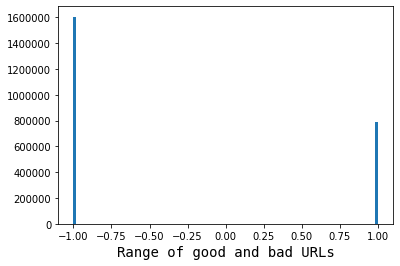

In [23]:
plt.hist(totalurls, 100)
plt.xlabel("Range of good and bad URLs", fontdict={'fontsize': 14, 'family': 'monospace'})
plt.show()

## Logistic regression

The first model that we will analyze is the Logistic regression model. We are taking one random sample of days for training and one for testing. From the training set of days we choose one random day and pass it as an input to train the model, the number of data used to train the model is 20000. Then we peek some random days from the testing set to test the model.

### Model definition

In [26]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=-1)

### Train-test split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3)

index = random_index(x_train)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Model training

Here we train the model with a random day from the training set and measure the time needed by the model for training

In [28]:
# fit the model with data
%time logreg.fit(x_train[index], y_train[index])

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 10.2 s, sys: 419 ms, total: 10.7 s
Wall time: 5.38 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

### Model validation

Here we try to predict the quality of some random urls and rank the goodness of the results 

In [29]:
# predict the response values for the observations in X
pred = logreg.predict(x_test[index])

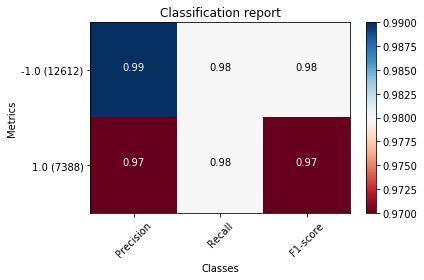

In [31]:
plot_classification_report(classification_report(y_test[index], pred))

The precision value means how good is the model in not making errors predicting the value of an URL, the recall value tells how good is the model in finding all the URLs of that particular class, finally the f1-score is basically a mean between these two previous values

Normalized confusion matrix
[[0.98128766 0.01871234]
 [0.02355171 0.97644829]]


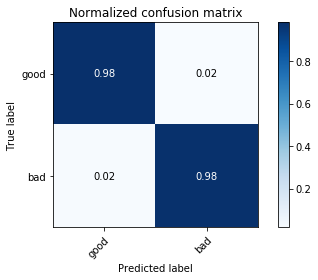

In [32]:
plot_confusion_matrix(y_test[index], pred, {'good','bad'}, normalize=True)

In [33]:
index = random_index(x_test, index)
pred = logreg.predict(x_test[index])

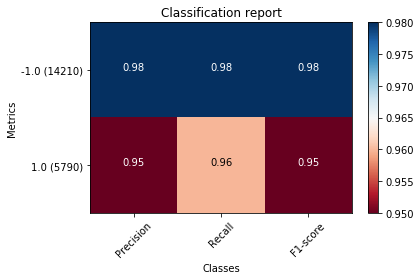

In [34]:
plot_classification_report(classification_report(y_test[index], pred))

Normalized confusion matrix
[[0.97987333 0.02012667]
 [0.04283247 0.95716753]]


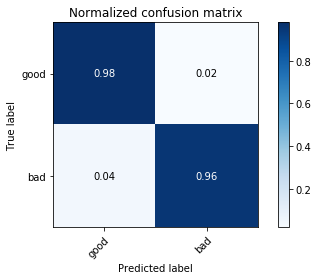

In [35]:
plot_confusion_matrix(y_test[index], pred, {'good','bad'}, normalize=True)

In [36]:
index = random_index(x_test, index)
pred = logreg.predict(x_test[index])

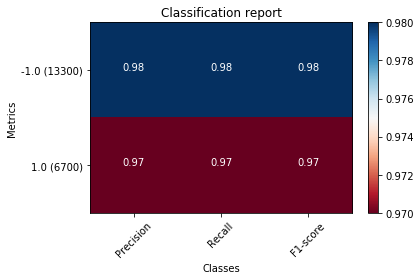

In [37]:
plot_classification_report(classification_report(y_test[index], pred))

Normalized confusion matrix
[[0.98263158 0.01736842]
 [0.03492537 0.96507463]]


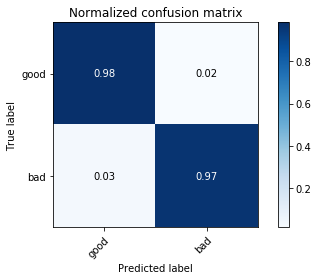

In [38]:
plot_confusion_matrix(y_test[index], pred, {'good','bad'}, normalize=True)

So here we can see that the model, with a very little training time is able to predict the quality of the URLs with a great accuracy

## SVM with raw data

Here we try to train and test a SVM model with the raw data of our dataset, as before we take one random set of days for training and one for testing. First we apply the GridSearch model on our SVM to find the best parameters ( C value and Kernel ) for our data. Then we test the model on some random days taken from the test set. As before we will use the same metrixes to quantify the quality of the model.

### Model definition

In [25]:
from sklearn import svm

estimator = svm.SVC(gamma='auto', random_state=0, probability=True)

param_grid = {
    'C': [0.1, 1.0, 20.0, 100.0],
    'kernel': ['rbf', 'poly', 'linear'],
}

grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=2)

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Training the model

First apply grid search model to find the best parameters to SVM

In [116]:
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=2)

In [117]:
index = random_index(x_train) 

In [118]:
%time grid_search.fit(x_train[index], y_train[index])

CPU times: user 1h 53min 18s, sys: 11.5 s, total: 1h 53min 30s
Wall time: 30min 29s


GridSearchCV(cache_cv=True, cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False),
       iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 20.0, 100.0], 'kernel': ['rbf', 'poly', 'linear']},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

It takes almost 30 minutes for training

<p>Here we can see the result of the cross validation test for the various combination of the parameters and some other informations</p>

In [119]:
pd.DataFrame(grid_search.cv_results_)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=Tru

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score,param_C,param_kernel
0,"{'C': 0.1, 'kernel': 'rbf'}",308.369061,8.702819,56.811756,0.690229,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,0.1,rbf
1,"{'C': 0.1, 'kernel': 'poly'}",291.262082,11.585879,49.855733,1.102404,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,0.1,poly
2,"{'C': 0.1, 'kernel': 'linear'}",49.869594,3.336660,7.730680,0.330571,0.975102,0.980298,0.97770,0.002598,1,0.997500,0.997500,0.997500,2.500000e-07,0.1,linear
3,"{'C': 1.0, 'kernel': 'rbf'}",313.701535,8.804138,52.670144,1.671675,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,1,rbf
4,"{'C': 1.0, 'kernel': 'poly'}",279.247259,6.617895,46.138575,0.086304,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,1,poly
5,"{'C': 1.0, 'kernel': 'linear'}",51.039631,3.784847,7.793320,0.440717,0.973603,0.980498,0.97705,0.003448,2,1.000000,1.000000,1.000000,0.000000e+00,1,linear
6,"{'C': 20.0, 'kernel': 'rbf'}",318.811352,10.993538,54.507265,2.195584,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,20,rbf
7,"{'C': 20.0, 'kernel': 'poly'}",273.386728,8.622309,47.079418,1.577512,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,20,poly
8,"{'C': 20.0, 'kernel': 'linear'}",51.538848,3.339830,8.123403,0.236409,0.973603,0.980398,0.97700,0.003398,3,1.000000,1.000000,1.000000,0.000000e+00,20,linear
9,"{'C': 100.0, 'kernel': 'rbf'}",291.251503,35.140097,48.511955,6.780016,0.703530,0.843684,0.77360,0.070077,5,0.807781,0.787321,0.797551,1.022976e-02,100,rbf


The choosen parameters are C = 0.1 and kernel = linear

In [120]:
grid_search.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [121]:
grid_search.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

### Model validation

In [140]:
%time result = grid_search.predict(x_test[25])

CPU times: user 17.6 s, sys: 411 µs, total: 17.6 s
Wall time: 17.6 s


In [143]:
print(classification_report(y_test[25], result))

              precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     13097
         1.0       0.95      0.97      0.96      6903

   micro avg       0.97      0.97      0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



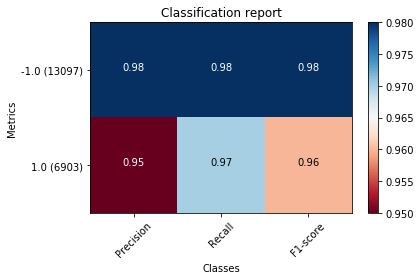

In [154]:
plot_classification_report(classification_report(y_test[25], result))

Normalized confusion matrix
[[0.97579598 0.02420402]
 [0.0318702  0.9681298 ]]


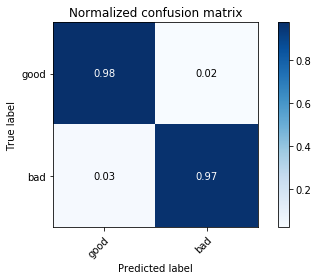

In [124]:
plot_confusion_matrix(y_test[25], result, ('good','bad'), normalize=True)

In [155]:
pred = grid_search.predict(x_test[27])

In [134]:
print(classification_report(y_test[27], pred))

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.99     13578
         1.0       0.97      0.97      0.97      6422

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



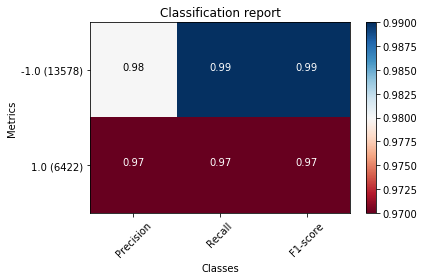

In [156]:
plot_classification_report(classification_report(y_test[27], pred))

Normalized confusion matrix
[[0.98652232 0.01347768]
 [0.03207723 0.96792277]]


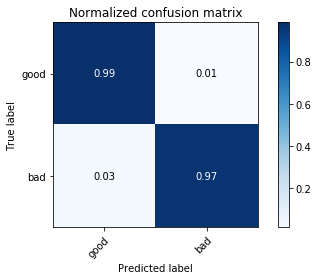

In [135]:
plot_confusion_matrix(y_test[27], pred, ('good','bad'), normalize=True)

In [157]:
index = random_index(x_test)
pred = grid_search.predict(x_test[index])

In [137]:
print(classification_report(y_test[index], pred))

              precision    recall  f1-score   support

        -1.0       0.98      0.97      0.97     13555
         1.0       0.94      0.95      0.95      6445

   micro avg       0.96      0.96      0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.96      0.96     20000



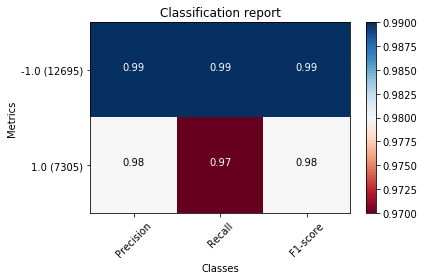

In [158]:
plot_classification_report(classification_report(y_test[index], pred))

Normalized confusion matrix
[[0.97248248 0.02751752]
 [0.05089216 0.94910784]]


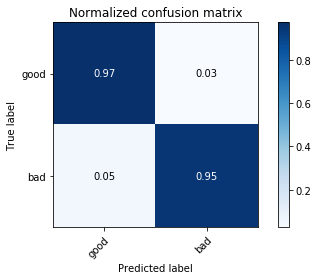

In [138]:
plot_confusion_matrix(y_test[index], pred, ('good','bad'), normalize=True)

So we can see, looking to the classification reports and the confusion matrixes, that the model is good trained and is able to predict the quality of random URLs with very low error rates. However it takes some time for training, about 30 minutes.

## Test on decomposed data

Here instead we try to apply SVM on dimensionally reducted data and see if the model is equally able to predict the quality of the URLs with a very low error score in a shorter time. Since we are dealing with sparse attributes we can not compute PCA to reduce the dimension of our dataset, instead we will use the Truncated SVD model which is a particular kind of PCA, used to reduce the dimension of sparse data.

### Truncated SVD

In [27]:
from sklearn.decomposition import TruncatedSVD

Lets first plot the data for day 0 with a 2 components decomposition

In [28]:
day0 = TruncatedSVD().fit_transform(x[0])

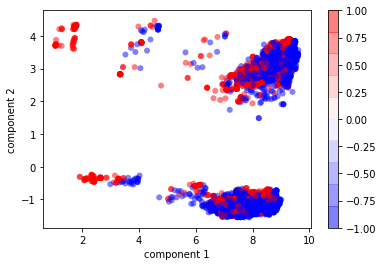

In [29]:
plt.scatter(day0[:, 0], day0[:, 1],
            c=y[0], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('bwr', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Since Truncated SVD is a model very complex computationally we are not able to reduce the dataset of only few components. Instead what we want to see is that, keeping only few components, we are able to explain much of the variance of the original dataset. For this test we are projecting our original dataset on a space made of only 25 eigenvectors.

In [30]:
svd = TruncatedSVD(n_components=25).fit(x[0])

Cumulative explained variance: 0.46161455754368325


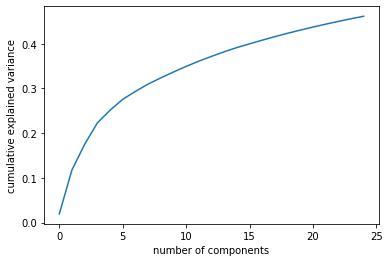

In [32]:
print("Cumulative explained variance:",sum(svd.explained_variance_ratio_))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Almost 45% of the original variance for day 0 is explained by these new components

In [31]:
mem_svd = Memory('./cache_svd')

In [32]:
#Save the result of the decomposition on a cache file, so that the future calls are faster
@mem_svd.cache
def get_svd_array(dataset):
    svd = TruncatedSVD(n_components=25)
    svd_dataset = np.array([svd.fit_transform(day) for day in dataset])
    return svd_dataset

In [33]:
svd_x = get_svd_array(x)

In [34]:
n_samples = len(svd_x) * svd_x[0].shape[0]
n_features = svd_x[0].shape[1]
n_classes = len(np.unique(y[0]))

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2380000
n_features: 25
n_classes: 2


Again here we split our dataset in training and testing and run the SVM classification on these data. We are using the same parameters for the SVM as before, since putting C=1 lets the model train for a time larger then before, making our analysis useless.

In [35]:
x_train, x_test, y_train, y_test = train_test_split(svd_x, y, train_size=0.3)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
estimator = svm.SVC(C=0.1, kernel='linear', gamma='auto', random_state=0, probability=True)

In [37]:
%time estimator.fit(x_train[0], y_train[0])

CPU times: user 12.8 s, sys: 121 ms, total: 12.9 s
Wall time: 13 s


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [38]:
pred = estimator.predict(x_test[0])

In [39]:
print(classification_report(y_test[0], pred, target_names=['good', 'bad']))

              precision    recall  f1-score   support

        good       0.78      0.82      0.80     13968
         bad       0.53      0.47      0.50      6032

   micro avg       0.71      0.71      0.71     20000
   macro avg       0.65      0.64      0.65     20000
weighted avg       0.70      0.71      0.71     20000



Normalized confusion matrix
[[0.82030355 0.17969645]
 [0.53282493 0.46717507]]


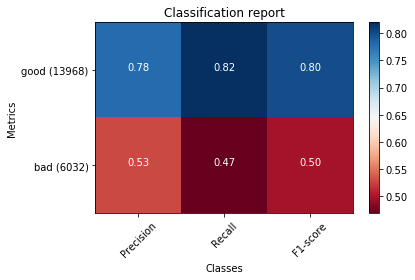

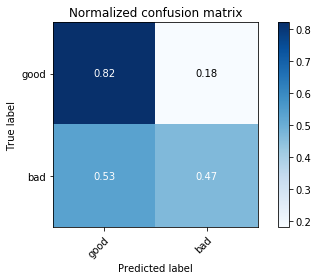

In [40]:
plot_classification_report(classification_report(y_test[0], pred, target_names=['good', 'bad']))
plot_confusion_matrix(y_test[0], pred, ('good','bad'), normalize=True)

In [41]:
pred = estimator.predict(x_test[1])

In [42]:
print(classification_report(y_test[1], pred, target_names=['good', 'bad']))

              precision    recall  f1-score   support

        good       0.65      0.71      0.68     13532
         bad       0.26      0.21      0.23      6468

   micro avg       0.55      0.55      0.55     20000
   macro avg       0.46      0.46      0.46     20000
weighted avg       0.53      0.55      0.54     20000



Normalized confusion matrix
[[0.71112918 0.28887082]
 [0.788188   0.211812  ]]


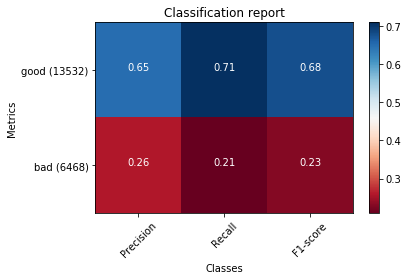

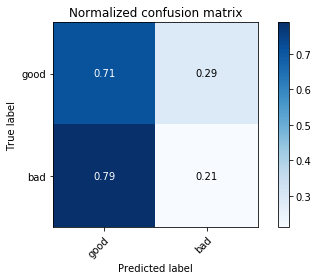

In [43]:
plot_classification_report(classification_report(y_test[1], pred, target_names=['good', 'bad']))
plot_confusion_matrix(y_test[1], pred, ('good','bad'), normalize=True)

In [44]:
index = random_index(x_train, 0)
pred = estimator.predict(x_test[5])

              precision    recall  f1-score   support

        good       0.69      0.73      0.71     13555
         bad       0.35      0.31      0.33      6445

   micro avg       0.59      0.59      0.59     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.58      0.59      0.59     20000

Normalized confusion matrix
[[0.72821837 0.27178163]
 [0.69262995 0.30737005]]


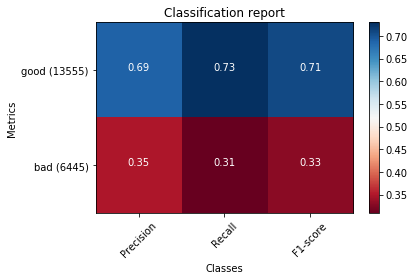

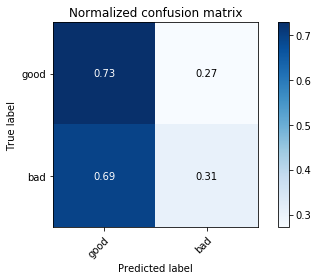

In [45]:
print(classification_report(y_test[5], pred, target_names=['good', 'bad']))
plot_classification_report(classification_report(y_test[5], pred, target_names=['good', 'bad']))
plot_confusion_matrix(y_test[5], pred, ('good','bad'), normalize=True)

So here we can see that, although the model requires a very little time for training and testing, he is not able to predict the quality of an URL with the same accuracy as before. In particular is not able to find bad URLs.

## Conclusions

<div>In this project we have analyzed the behaviour of different classification models on a very huge dataset. 
Sampling is the only way to manage these data, since is impossible for us to do computations on the entire dataset at the same time.</div>
<div>
The <b>logistic regression</b> model is the best in terms of performance since it takes very short time for training but is able to predict the quality of an URL with a very high accuracy.
</div>
<div>
    Training and testing a <b>SVM model</b> with 20000 random samples of the raw data is a bit heavy computationally, since it takes almost 30 minutes to train, but gives us a very good model for predicting the quality of an URL.
</div>
<div>
    Instead applying the SVM model on a 25 component <b>decomposed dataset</b> is more easy computationally but gives us a model which is not very good in predict the quality of an URL. The bad accuracy of the model can be explained by the low amount of eigenvectors used to project the original data, in fact they explain only less than the 50% of the original variance of the dataset. If we had more computational power to compute more eigenvectors, the quality of the model would have increased.</div>
<div>So finally we can conclude that the logistic regression model is the best to apply on this huge dataset since combines an easy computation of 20000 sample URLs with a very hig accuracy of the predictions.</div>